# Hairsalon  Database


## About this notebook

This notebook was created to help with the initial analysis of the hair salon database.


In [188]:
import numpy as np
import datetime as dt
import pandas as pd
import workdays as wd  #packahe used to calculate diff business days
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
sns.set(style="darkgrid")
ROOT_PATH="C:/Users/moshe/Documents/projectML/p1"
DATA_PATH = "%s/data/raw" % ROOT_PATH
DB_FILE = "%s/hairsalon.db" % DATA_PATH
import sqlite3 as sql3
db=sql3.connect(DB_FILE)

In [2]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################

#### List the name of the tables on the database 
def listTables():
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    res = cur.fetchall()
    cur.close()
    db.close()
    return(res)

#### Read function to import data from the SQL to a pandas dataframe.
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
def writeSQL(df,tablename,overwrite=False, append=False):
    import pandas as pd
    import sqlite3 as sql
    db = sql.connect(DB_FILE)
    if (overwrite):
        action = "replace"
    elif (append):
        action = "append"
    else: 
        action = "fail"
    df.to_sql(tablename, db, if_exists=action)
    db.close()

#### Generate a view based on the provided SQL query
def createView(viewname, query):
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    view = 'CREATE VIEW {} AS {}'.format(viewname,query)
    #view = """CREATE VIEW ? AS 
    #?"""
    cur = db.cursor()
    #cur.execute(view, viewname, query)
    cur.execute(view)
    cur.close()
    db.close()

def execquery (query):
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute(query)
    cur.close()
    db.close()
     

<h1> import from csv data into sqltables to run once recreates all tables </h1>

In [174]:
import pandas as pd
file_tuple=("Client Cancellations0","Future Bookings (All Clients)0","No-Show Report0",
            "Product Listing (Retail)0","Receipt Transactions0","Service Listing0")
table_tuple=("cancellation","futurebooking","noshow","product","receipt","service")
tableiter=iter(table_tuple)

#loop over csv files and crate a correpsonding table for each file 
for f in file_tuple:
    file=f'{DATA_PATH}/{f}.csv'
    df=pd.read_csv(file)
    #rename columns remove spaces and lower allcharacters
    df.rename(columns=lambda x:x.replace(" ",""),inplace=True)
    df.rename(columns=lambda x:x.lower(),inplace=True)
    df.to_sql(next(tableiter),db,if_exists='replace',index=False)

In [175]:
db.commit()

In [176]:
cancellations = readSQL('''SELECT * FROM cancellation''')
cancellations.head()

,canceldate,code,service,staff,bookingdate,canceledby,days
0,05/22/2018,MASA01,CFC,JOANNE,05/24/2018,ADMIN,2.0
1,06/27/2018,MASA01,CBAL,KELLY,06/27/2018,ADMIN,0.0
2,07/03/2018,MASA01,SHCM,BECKY,07/10/2018,BECKY,7.0
3,07/10/2018,MASA01,SHCC,JJ,07/11/2018,KELLY,1.0
4,07/24/2018,TRUA01,SHCM,KELLY,07/24/2018,TANYA,0.0


In [177]:
futurebookings=readSQL('''SELECT * FROM futurebooking''')
futurebookings.head()

,code,staff,service,date,time,timeint
0,JUNJ01,JJ,CON,03/14/2018,3:50:00 PM,950
1,NORJ01,JJ,SHCM,03/14/2018,4:00:00 PM,960
2,CORS01,JJ,SHCW,03/15/2018,2:10:00 PM,850
3,KERT01,JJ,SHCW,03/15/2018,10:00:00 AM,600
4,LEHJ01,JJ,SHCM,03/15/2018,6:00:00 PM,1080


In [178]:
receipts=readSQL('''SELECT * FROM receipt''')
receipts.head()

,receipt,date,description,client,staff,quantity,amount,gst,pst
0,10,03/15/2018,Women's hair cut,KERT01,JJ,1,82.0,4.10,6.56
1,100,04/05/2018,Women's hair cut,COOM01,SINEAD,1,70.0,3.50,5.60
2,1000,06/09/2018,Consultation,PEDM01,JJ,1,0.0,0.00,0.00
3,1001,06/09/2018,Women's hair cut,BAIS01,KELLY,1,55.0,2.75,4.40
4,1003,06/09/2018,Women's hair cut,FRAL01,KELLY,1,65.0,3.25,5.20


In [179]:
noshows=readSQL('''SELECT * FROM noshow''')
noshows.head()

,date,code,service,staff
0,04/13/2018,None,SHCW,JJ
1,07/27/2018,AMAB01,SHCM,KELLY
2,06/07/2018,APPS01,SBD,KELLY
3,06/05/2018,ASIS01,SHCW,KELLY
4,05/31/2018,BISD01,CON,SINEAD


In [180]:
products=readSQL('''SELECT * FROM product''')
products.head()

,isactive,code,description,supplier,brand,category,price,onhand,minimum,maximum,cost,cog,ytd,package
0,1,AGBALANCE335M,AG balance 355ml,VENUS,AG,RETAIL,30.0,2,2,2,0.0,0.0,27.0,0
1,1,AGBOOST355ML,AG Boost 355ml,VENUS,AG,RETAIL,30.0,3,2,2,18.0,54.0,0.0,0
2,1,AGCLOUD107ML,AG Cloud 107ml,VENUS,AG,RETAIL,26.0,4,2,2,15.6,62.4,23.4,0
3,1,AGDRYLIFT44ML,AG Dry Lift 44ml,VENUS,AG,RETAIL,24.0,1,2,2,14.4,14.4,43.2,0
4,1,AGREMEDY148ML,AG Remedy 148ml,VENUS,AG,RETAIL,26.0,3,2,2,15.6,46.8,0.0,0


In [181]:
services=readSQL('''SELECT * FROM service''')
services.head()

,isactive,code,desc,cate,price,cost
0,1,CAL,accent lights,COLOR,0,10
1,1,CALC,Accent lights and color,COLOR,0,10
2,1,CAS,Color additional service,COLOR,0,10
3,1,CBAL,Balayage,COLOR,0,10
4,1,CCAMO,Men's camo color,COLOR,45,5


In [182]:
#SQLITE DB date and time are saved as text values - the code below updates the format in the DB
#converts format date MM/DD/YYYY =>ISO FORMAT 8601 YYYY-DD-MM
#converts format date 3:50:0 PM =>ISO FORMAT HH:MM:SS
import datetime as dt
cancellations['canceldate']=pd.to_datetime(cancellations['canceldate'],format="%m/%d/%Y")
cancellations['canceldate'] = cancellations['canceldate'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
cancellations['bookingdate']=pd.to_datetime(cancellations['bookingdate'],format="%m/%d/%Y")
cancellations['bookingdate'] = cancellations['bookingdate'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
cancellations.to_sql('cancellation',db,if_exists='replace',index=False)

futurebookings['date']=pd.to_datetime(futurebookings['date'],format="%m/%d/%Y")
futurebookings['date'] = futurebookings['date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
futurebookings['time']=pd.to_datetime(futurebookings['time'],infer_datetime_format=True)
futurebookings['time'] = futurebookings['time'].apply(lambda x: dt.datetime.strftime(x, '%H:%M:%S'))
futurebookings.to_sql('futurebooking',db,if_exists='replace',index=False)

receipts['date']=pd.to_datetime(receipts['date'],format="%m/%d/%Y")
receipts['date'] = receipts['date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
receipts.to_sql('receipt',db,if_exists='replace',index=False)

#converts format date MM/DD/YY =>ISO FORMAT 8601 YYYY-DD-MM
noshows['date']=pd.to_datetime(noshows['date'],format="%m/%d/%Y")
noshows['date'] = noshows['date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
noshows.to_sql('noshow',db,if_exists='replace',index=False)

In [40]:
query = """SELECT MIN(canceldate), MAX(canceldate), MIN(bookingdate), Max (bookingdate),min(days),max(days),count(*)
         FROM cancellation"""
resquery = readSQL(query)
resquery

,MIN(canceldate),MAX(canceldate),MIN(bookingdate),Max (bookingdate),min(days),max(days),count(*)
0,2018-03-27,2018-07-28,2018-03-29,2018-09-21,-37.0,66.0,243


In [41]:
query = """SELECT MIN(date), MAX(date), count(*)
         FROM noshow"""
resquery = readSQL(query)
resquery

,MIN(date),MAX(date),count(*)
0,2018-03-14,2018-07-29,60


In [3]:
query = """SELECT MIN(date), MAX(date), Min(Time),Max(time), count(*)
         FROM futurebooking"""
resquery = readSQL(query)
resquery

,MIN(date),MAX(date),Min(Time),Max(time),count(*)
0,2018-03-14,2019-02-15,08:00:00,19:30:00,1906


In [43]:
query = """SELECT MIN(date), MAX(date),MIN(amount),MAX(amount), count(*)
         FROM receipt """
resquery = readSQL(query)
resquery

,MIN(date),MAX(date),MIN(amount),MAX(amount),count(*)
0,2018-03-15,2018-07-29,-52.0,300.0,1934


In [44]:
#A receipt can count several sub-receipts for different services or products
query = """SELECT count(*), count(distinct receipt) 
         FROM receipt """
resquery = readSQL(query)
resquery

,count(*),count(distinct receipt)
0,1934,1436


In [4]:
#nb of sub-receipts vary from one to six
query = """
SELECT count(*) receipts, subreceiptcnt nbsubreceipts FROM
(SELECT count(*) subreceiptcnt, receipt 
         FROM receipt group by receipt)
group by subreceiptcnt"""
resquery = readSQL(query)
resquery

,receipts,nbsubreceipts
0,1047,1
1,309,2
2,57,3
3,18,4
4,4,5
5,1,6


In [48]:
#All services listed in futurebooking are services defined in service table [same number of rows]
query= """select count(*) from futurebooking fb
        inner join service s on fb.service=s.code"""
resquery = readSQL(query)
resquery

,count(*)
0,1906


In [189]:
#part of the receipts are for services
query= """select count(*) from receipt r
        inner join service s on r.description=s.desc
        WHERE r.description is NOT NULL
        """
resquery = readSQL(query)
resquery

,count(*)
0,1758


In [190]:
#part of the receipts are for products
query= """select count(*) from receipt r
        inner join product p on r.description=p.description WHERE r.description is NOT NULL"""
resquery = readSQL(query)
resquery

,count(*)
0,173


In [191]:
#part of the receipts are not indicated with services or services
query= """select count(*) from receipt r 
        left join product p on r.description=p.description 
        left join service s on r.description=s.desc
        where p.description is NULL and s.desc is NULL"""
resquery = readSQL(query)
resquery

,count(*)
0,3


In [92]:
query="""drop view vfb"""
execquery(query)
query="""select fb.*, s.desc description, s.cate category from futurebooking fb 
inner join service s on fb.service=s.code """
createView('vfb',query)

In [204]:
#noshows  linked to a booking
query="""select n.* from noshow n
    inner join futurebooking fb  
    on n.date=fb.date and n.code=fb.code and n.service=fb.service and n.staff=fb.staff"""
resquery=readSQL(query)
resquery.shape

(59, 4)

In [205]:
#noshows that are not  linked apparently not linked directly to a booking #we must keep it for missing handling
query="""select n.* from noshow n
    left join futurebooking fb  
    on n.date=fb.date and n.code=fb.code and n.service=fb.service and n.staff=fb.staff
    where fb.date is null or fb.code is null or fb.service is null or fb.staff is null"""
resquery=readSQL(query)
resquery.head()

,date,code,service,staff
0,2018-04-13,None,SHCW,JJ


In [268]:
#there is a missing customer we will need to check this row
query="""select * from futurebooking fb  
    where fb.date='2018-04-13' and fb.service='SHCW' and fb.staff='JJ' """
resquery=readSQL(query)
resquery

,code,staff,service,date,time,timeint
0,None,JJ,SHCW,2018-04-13,18:00:00,1080
1,ALLM01,JJ,SHCW,2018-04-13,11:50:00,710
2,MOLA01,JJ,SHCW,2018-04-13,16:20:00,980
3,ROSL01,JJ,SHCW,2018-04-13,14:00:00,840


#Verifying that there is not twice the same appointment by the same person on the same day for the same service 

In [212]:
query="""select count(*), fb.date,fb.code,fb.service,fb.staff from futurebooking fb 
      group by fb.date,fb.code,fb.service,fb.staff
      having count(*)>1"""
resquery=readSQL(query)
resquery.head()

,count(*),date,code,service,staff


Appointments were cancelled and booked on the same day by a customer 
A diffferent staff was assgined or maybe different service 
we might not take them into account as late cancellation
We need to understand the cause we will further investigate 
some appointments for the same person were cancelled twice or even 4 times !

In [50]:
query="""select fb.code, fb.staff,fb.service, fb.date from futurebooking fb inner join cancellation c
where fb.date=c.bookingdate and fb.code=c.code """
resquery=readSQL(query)
resquery.head()

,code,staff,service,date
0,SARA01,JJ,SHCM,2018-04-04
1,HUDM01,JJ,CHLFH,2018-04-08
2,STEM01,BECKY,SHCW,2018-04-21
3,BUSM01,SINEAD,SHCW,2018-04-26
4,MOIB01,SINEAD,SHCW,2018-04-26


In [197]:
#All services defined in table cancellation are defined in table services
query="""select  count(*) from vcancellation c where description is NULL"""
resquery=readSQL(query)
resquery

,count(*)
0,0


In [96]:
query="""drop view vcancellation"""
execquery(query)
query="""select c.*, s.desc description, s.cate category from cancellation c 
inner join service s on c.service=s.code """
createView('vcancellation',query)

In [97]:
#All services defined in table futurebookings are defined in table services
query="""select  count(*) from vfb c where description is NULL"""
resquery=readSQL(query)
resquery

,count(*)
0,0


In [70]:
#create extended view of receipt 
query="""drop view vreceipt"""
execquery(query)
query="""select r.*,s.code service, 'S' type, s.cate category 
            from receipt r inner join service s on r.description=s.desc
union all
            select r.*,p.code service, 'P' type, p.category category 
            from receipt r inner join product p on r.description=p.description
union all
            select r.*, NULL service, NULL type, NULL category
            from receipt r
            left join service s on r.description=s.desc
            left join product p on r.description=p.description 
            where s.desc IS NULL and p.description IS NULL """
createView('vreceipt',query)
resquery=readSQL("""select * from vreceipt """)
resquery.head()

,receipt,date,description,client,staff,quantity,amount,gst,pst,service,type,category
0,10,2018-03-15,Women's hair cut,KERT01,JJ,1,82.0,4.10,6.56,SHCW,S,STYLE
1,100,2018-04-05,Women's hair cut,COOM01,SINEAD,1,70.0,3.50,5.60,SHCW,S,STYLE
2,1000,2018-06-09,Consultation,PEDM01,JJ,1,0.0,0.00,0.00,CON,S,MISC
3,1001,2018-06-09,Women's hair cut,BAIS01,KELLY,1,55.0,2.75,4.40,SHCW,S,STYLE
4,1003,2018-06-09,Women's hair cut,FRAL01,KELLY,1,65.0,3.25,5.20,SHCW,S,STYLE


In [13]:
cancellation=readSQL("""select * from cancellation""")
print('cancellation', len(cancellation))
futurebooking=readSQL("""select * from futurebooking""")
print('futurebooking',len(futurebooking))
noshow=readSQL("""select * from noshow""")
print('noshow',len(noshow))
receipt=readSQL("""select * from receipt""")
receipt.head()
print('receipt',len(receipt))

cancellation 243
futurebooking 1906
noshow 60
receipt 1934


In [14]:
query="""select * from vfb"""
vfb=readSQL(query)
vfb.shape

(1906, 8)

In [15]:
vfb.rename(columns={'code':'client'},inplace=True)
print('vfb', len(vfb))
vfb.columns

vfb 1906


Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category'],
      dtype='object')

In [16]:
vcancellation=readSQL("""select * from vcancellation""")
print('vcancellation', len(vcancellation))
vcancellation.columns

vcancellation 243


Index(['canceldate', 'code', 'service', 'staff', 'bookingdate', 'canceledby',
       'days', 'description', 'category'],
      dtype='object')

In [17]:
vcancellation.rename(columns={'bookingdate':'date','code':'client'},inplace=True)
vcancellation.columns

Index(['canceldate', 'client', 'service', 'staff', 'date', 'canceledby',
       'days', 'description', 'category'],
      dtype='object')

In [18]:
vreceipt=readSQL("""select * from vreceipt """)
len(vreceipt)

1934

In [19]:
vreceipt.columns

Index(['receipt', 'date', 'description', 'client', 'staff', 'quantity',
       'amount', 'gst', 'pst', 'service', 'type', 'category'],
      dtype='object')

In [20]:
noshow.rename(columns={'code':'client'},inplace=True)
noshow.columns

Index(['date', 'client', 'service', 'staff'], dtype='object')

<h3>missing values analysis

In [21]:
vcancellation.isna().sum()

canceldate     0
client         0
service        0
staff          0
date           0
canceledby     0
days           2
description    0
category       0
dtype: int64

In [22]:
#future booking and past non cancelled bookings
vfb.isna().sum()

client         1
staff          0
service        0
date           0
time           0
timeint        0
description    0
category       0
dtype: int64

In [23]:
noshow.isna().sum()

date       0
client     1
service    0
staff      0
dtype: int64

In [24]:
receipt.isna().sum()

receipt        0
date           0
description    3
client         0
staff          0
quantity       0
amount         0
gst            0
pst            0
dtype: int64

In [25]:
vreceipt.isna().sum()

receipt        0
date           0
description    3
client         0
staff          0
quantity       0
amount         0
gst            0
pst            0
service        3
type           3
category       9
dtype: int64

<h2> building final data set 

building data set of future and non cancelled bookings it includes no shows

We will suppress all bookings that occur after 2018-07-29. No receipts are produced after this date (see MAX receipt date) Therefore we have no way of understanding what happened after this date

In [92]:
query="""select vfb.code client,vfb.staff,vfb.service, vfb.date, vfb.time,vfb.timeint, 
        description, category,
        CASE 
        WHEN (vfb.date IS NULL or vfb.code IS NULL or vfb.service IS NULL or vfb.staff IS NULL) THEN NULL  
        WHEN (n.date IS NULL or n.code IS NULL or n.service IS NULL or n.staff IS NULL) THEN 0 
        ELSE 1 END as noshowflag 
        FROM vfb
        LEFT JOIN noshow n on vfb.date=n.date and vfb.code=n.code and vfb.service=n.service and vfb.staff=n.staff
        WHERE vfb.date <= '2018-07-29' or vfb.date IS NULL
        """
bookings=readSQL(query)
bookings['canceldate']=None
bookings['canceledby']=None
bookings.columns

Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category', 'noshowflag', 'canceldate', 'canceledby'],
      dtype='object')

In [93]:
bookings.isna().sum()

client            1
staff             0
service           0
date              0
time              0
timeint           0
description       0
category          0
noshowflag        1
canceldate     1717
canceledby     1717
dtype: int64

<h4>building list of all cancellations including late minute cancellations

In [95]:
cancellations2=vcancellation.copy()
cancellations2['noshowflag']=0
cancellations2['deltabdays']=None
cancellations2=cancellations2[['client','staff','service','date','description','category',
                               'noshowflag','canceldate','canceledby','deltabdays']]
cancellations2.columns

Index(['client', 'staff', 'service', 'date', 'description', 'category',
       'noshowflag', 'canceldate', 'canceledby', 'deltabdays'],
      dtype='object')

In [96]:
cancellations2.isna().sum()

client           0
staff            0
service          0
date             0
description      0
category         0
noshowflag       0
canceldate       0
canceledby       0
deltabdays     243
dtype: int64

In [97]:
cancellations2=cancellations2[cancellations2.canceldate <= '2018-07-28']
cancellations2.isna().sum()

client           0
staff            0
service          0
date             0
description      0
category         0
noshowflag       0
canceldate       0
canceledby       0
deltabdays     243
dtype: int64

In [98]:
print('cancellation', len(cancellations2))
print('booking',len(bookings))
print('noshow',len(noshow))
print('receipt',len(receipt))

cancellation 243
booking 1717
noshow 60
receipt 1934


<h6>calculating difference of business days to determine late cancellations that are equivalent to noshow

In [165]:
import datetime as dt
import workdays

#salon is open on all days execpt monday
wd.weekends=(0,) 
#ontorio holidays
holidays=[dt.date(2018,3,30),dt.date(2018,5,21),dt.date(2018,7,1)]
wd.weekends
delta=[]
for row in cancellations2.itertuples():
    sd=pd.to_datetime(row.canceldate).date()
    ed=pd.to_datetime(row.date).date()
    if sd==ed:
        nbwd=0
    else:
        nbwd=wd.networkdays(sd,ed,holidays)-1
    delta.append(nbwd)
cancellations2.deltabdays=delta
cancellations2.dtypes

client              object
staff               object
service             object
date                object
description         object
category            object
noshowflag           int64
canceldate          object
canceledby          object
deltabdays           int64
latecancellation     int64
dtype: object

In [166]:
cancellations2.head()

,client,staff,service,date,description,category,noshowflag,canceldate,canceledby,deltabdays,latecancellation
0,MASA01,JOANNE,CFC,2018-05-24,Color full color,COLOR,0,2018-05-22,ADMIN,2,0
1,MASA01,KELLY,CBAL,2018-06-27,Balayage,COLOR,1,2018-06-27,ADMIN,0,1
2,MASA01,BECKY,SHCM,2018-07-10,Men's hair cut,STYLE,0,2018-07-03,BECKY,6,0
3,MASA01,JJ,SHCC,2018-07-11,Children (under 12),STYLE,0,2018-07-10,KELLY,1,1
4,TRUA01,KELLY,SHCM,2018-07-24,Men's hair cut,STYLE,1,2018-07-24,TANYA,0,1


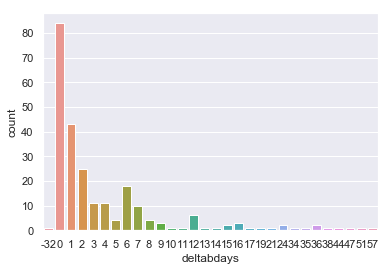

In [167]:
#indicates the number of business days between cancellation and appointment day
ax = sns.countplot(x="deltabdays", data=cancellations2)

In [168]:
cancellations2[(cancellations2.deltabdays<0)]

,client,staff,service,date,description,category,noshowflag,canceldate,canceledby,deltabdays,latecancellation
154,KOOM01,JJ,SHCW,2018-04-03,Women's hair cut,STYLE,0,2018-05-10,JJ,-32,0


In [170]:
cancellations2["latecancellation"]=0
cancellations2["noshowflag"]=0
cancellations2.loc[((cancellations2.deltabdays==0) | (cancellations2.deltabdays==1)),"latecancellation"]=1
print('late cancellation day',len(cancellations2[(cancellations2.latecancellation==1)]))
cancellations2.loc[(cancellations2.deltabdays==0),"noshowflag"]=1
print('cancellation done one day before appointment day',len(cancellations2[(cancellations2.latecancellation==1) & (cancellations2.noshowflag==0)]))
print('cancellation done on appointment day',len(cancellations2[(cancellations2.noshowflag==1)]))
cancellations2.columns

late cancellation day 127
cancellation done one day before appointment day 43
cancellation done on appointment day 84


Index(['client', 'staff', 'service', 'date', 'description', 'category',
       'noshowflag', 'canceldate', 'canceledby', 'deltabdays',
       'latecancellation'],
      dtype='object')

In [175]:
#data frame of cancellations without no noshow includes late cancellations
cancellation3=cancellations2.copy()
cancellationearly=cancellation3[(cancellation3.latecancellation==0)]
cancellationnoshow=cancellation3[(cancellation3.noshowflag==1)]
cancellationeve=cancellation3[(cancellation3.noshowflag==0) & (cancellation3.latecancellation==1)]
len(cancellation3)

243

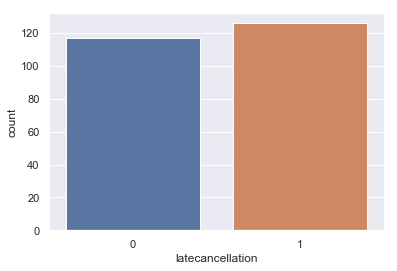

In [172]:
ax = sns.countplot(x="latecancellation", data=cancellations3)

<h6> concatenating effective bookings with cancellations done on the day  

In [173]:
print('cancellation no show',len(cancellationnoshow))
print('bookings',len(bookings))
bookings.columns

cancellation no show 84
bookings 1717


Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category', 'noshowflag', 'canceldate', 'canceledby'],
      dtype='object')

In [107]:
cancellationnoshow.columns

Index(['client', 'staff', 'service', 'date', 'description', 'category',
       'noshowflag', 'canceldate', 'canceledby', 'deltabdays',
       'latecancellation'],
      dtype='object')

In [143]:
fbooking=pd.concat([bookings,cancellationnoshow],sort=False)
len(fbooking)

1799

In [135]:
fbooking2=fbooking.copy()
fbooking2.dtypes

client               object
staff                object
service              object
date                 object
time                 object
timeint             float64
description          object
category             object
noshowflag          float64
canceldate           object
canceledby           object
deltabdays          float64
latecancellation    float64
dtype: object

In [153]:
fbooking2.isna().sum()

client                 1
staff                  0
service                0
date                   0
time                  82
timeint               82
description            0
category               0
noshowflag             1
canceldate          1717
canceledby          1717
deltabdays          1717
latecancellation    1717
tdate               1717
dtype: int64

In [184]:
fbooking2['dayinweek']=pd.to_datetime(fbooking2['date']).apply(lambda x: x.weekday()).astype('category')
fbooking2
fbooking2['staff']=fbooking2.staff.astype('category')
fbooking2['category']=fbooking2.category.astype('category')
fbooking2['dayinweek'].unique()
fbooking2[fbooking2.dayinweek==0]

,client,staff,service,date,time,timeint,description,category,noshowflag,canceldate,canceledby,deltabdays,latecancellation,tdate,dayinweek
179,BLAR01,BECKY,SHCW,2018-04-16,11:30:00,690.0,Women's hair cut,STYLE,0.0,None,None,NaN,NaN,0,0


In [160]:
fbooking2.dtypes

client                object
staff               category
service               object
date                  object
time                  object
timeint              float64
description           object
category            category
noshowflag           float64
canceldate            object
canceledby            object
deltabdays           float64
latecancellation     float64
tdate               category
dayinweek           category
dtype: object

In [189]:
serie2=pd.series
series.hist()
pyplot.show()

array([736767., 736767., 736768., ..., 736820., 736852., 736818.])

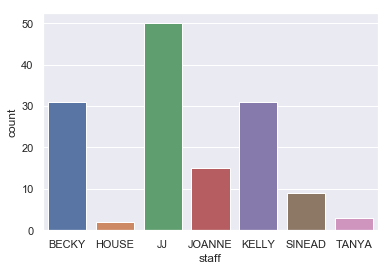

In [138]:
ax = sns.countplot(x="staff",data=fbooking2[fbooking.noshowflag==1])

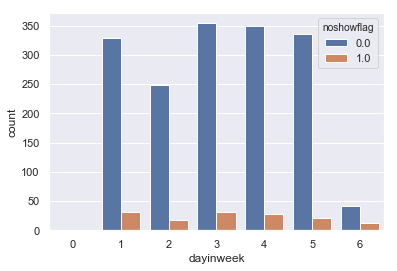

In [177]:
ax = sns.countplot(x="dayinweek",hue="noshowflag",data=fbooking2)

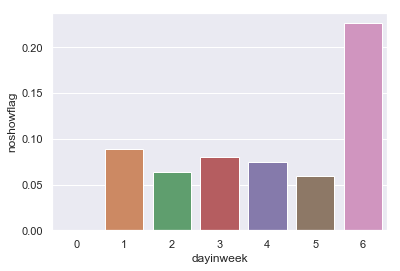

In [183]:
ax = sns.barplot(x="dayinweek",y="noshowflag",data=fbooking2,ci=None)

In [58]:
#there are customers with more than one  appointment on the same day
query="""select count(*),code,date from vfb 
where vfb.date <= '2018-07-29'
group by code,date having count(*) >=2"""
resquery=readSQL(query)
resquery.head()

,count(*),code,date
0,2,.L01,2018-05-23
1,2,ADAP01,2018-06-28
2,3,ALCV01,2018-06-12
3,4,ANDJ01,2018-05-22
4,2,ARRM01,2018-06-08


In [13]:
""#create extended view of receipt 
query="""drop view vreceipt"""
execquery(query)
query="""select r.*,s.code service, 'S' type, s.cate category 
            from receipt r inner join service s on r.description=s.desc
union all
            select r.*,p.code service, 'P' type, p.category category 
            from receipt r inner join product p on r.description=p.description
union all
            select r.*, NULL service, NULL type, NULL category
            from receipt r
            left join service s on r.description=s.desc
            left join product p on r.description=p.description 
            where s.desc IS NULL and p.description IS NULL """
createView('vreceipt',query)
resquery=readSQL("""select * from vreceipt where type='P'""")
resquery.head()

,receipt,date,description,client,staff,quantity,amount,gst,pst,service,type,category
0,1015,2018-06-12,Shu cleansing oil sh400ml,LEL01,KELLY,1,50.40,2.5200,4.0320,SHU CO SH400M,P,RETAIL
1,1021,2018-06-12,PO hydrate sh 250ml,LINM02,JJ,1,30.73,1.5365,2.4584,POHSH250ML,P,RETAIL
2,1040,2018-06-13,PO CV instant levitation mist,COLJ02,JJ,1,35.40,1.7700,2.8320,POCVILM145M,P,RETAIL
3,1062,2018-06-14,PO strength cure sh 250ml,CAYK01,JOANNE,1,30.73,1.5365,2.4584,POSCSH250ML,P,RETAIL
4,1071,2018-06-15,KM Night Rider 100g,KLEA01,BECKY,1,28.80,1.4400,2.3040,KM NR 100G,P,RETAIL


<h3>create merged dataframe bookings and services receipts <h3>

In [14]:
receipts=readSQL("""select * from vreceipt""")
bookings=readSQL("""select * from vbooking""")
noshows=readSQL("""select * from noshow""")
len(bookings)

2149

In [5]:
receipts.columns

Index(['receipt', 'date', 'description', 'client', 'staff', 'quantity',
       'amount', 'gst', 'pst', 'service', 'type', 'category'],
      dtype='object')

In [6]:
bookings.columns

Index(['client', 'staff', 'service', 'date', 'time', 'canceldate',
       'description', 'category', 'noshowflag', 'cancelflag'],
      dtype='object')

In [18]:
receipts2=receipts.copy()
receipts2.groupby(['date','description','client','staff','service','category']).


AttributeError: Cannot access attribute 'columns' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [15]:
result = pd.merge(bookings,receipts[['receipt', 'date', 'description', 'client', 'staff', 
                                     'quantity','amount', 'service', 'type', 'category']]
                  ,on= ['date','description','client','staff','service','category']
                  ,how='left',indicator=True)
len(result)

2151

In [13]:
result.head()

,client,staff,service,date,time,canceldate,description,category,noshowflag,cancelflag,receipt,quantity,amount,type,_merge
0,JUNJ01,JJ,CON,2018-03-14,15:50:00,None,Consultation,MISC,1,0,NaN,NaN,NaN,NaN,left_only
1,NORJ01,JJ,SHCM,2018-03-14,16:00:00,None,Men's hair cut,STYLE,1,0,NaN,NaN,NaN,NaN,left_only
2,CORS01,JJ,SHCW,2018-03-15,14:10:00,None,Women's hair cut,STYLE,0,0,8.0,1.0,82.0,S,both
3,KERT01,JJ,SHCW,2018-03-15,10:00:00,None,Women's hair cut,STYLE,0,0,10.0,1.0,82.0,S,both
4,LEHJ01,JJ,SHCM,2018-03-15,18:00:00,None,Men's hair cut,STYLE,0,0,13.0,1.0,40.0,S,both


In [16]:
result.to_sql('result',db,if_exists='replace',index=False)

In [12]:
bookings.dtypes

client         object
staff          object
service        object
date           object
time           object
canceldate     object
description    object
category       object
noshowflag      int64
cancelflag      int64
dtype: object